# Config

In [137]:
# config

label = 'y'
metric = 'mean_absolute_error'
time_limit = 60*30
presets = 'best_quality'

do_drop_ds = True
# hour, dayofweek, dayofmonth, month, year
use_dt_attrs = []#["hour", "year"]
use_estimated_diff_attr = False
use_is_estimated_attr = True

to_drop = ["snow_drift:idx", "snow_density:kgm3", "wind_speed_w_1000hPa:ms", "dew_or_rime:idx", "prob_rime:p", "fresh_snow_12h:cm", "fresh_snow_24h:cm", "wind_speed_u_10m:ms", "wind_speed_v_10m:ms", "snow_melt_10min:mm", "rain_water:kgm2", "dew_point_2m:K", "precip_5min:mm", "absolute_humidity_2m:gm3", "air_density_2m:kgm3", "msl_pressure:hPa", "pressure_50m:hPa",  "pressure_100m:hPa"]


use_groups = False
n_groups = 8

auto_stack = False
num_stack_levels = 0
num_bag_folds = 8
num_bag_sets = 20

use_tune_data = True
use_test_data = False
tune_and_test_length = 0.5 # 3 months from end
holdout_frac = None
use_bag_holdout = True # Enable this if there is a large gap between score_val and score_test in stack models. 

sample_weight = None#'sample_weight' #None
weight_evaluation = False#
sample_weight_estimated = 1
sample_weight_may_july = 1

run_analysis = False


shift_predictions_by_average_of_negatives_then_clip = False
clip_predictions = True
shift_predictions = False

# Loading and preprocessing

In [138]:
import pandas as pd
import numpy as np



import warnings
warnings.filterwarnings("ignore")


def feature_engineering(X):
    # shift all columns with "1h" in them by 1 hour, so that for index 16:00, we have the values from 17:00
    # but only for the columns with "1h" in the name
    #X_shifted = X.filter(regex="\dh").shift(-1, axis=1)
    #print(f"Number of columns with 1h in name: {X_shifted.columns}")


    columns = ['clear_sky_energy_1h:J', 'diffuse_rad_1h:J', 'direct_rad_1h:J',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm']
    
    X_shifted = X[X.index.minute==0][columns].copy()
    # loop through all rows and check if index + 1 hour is in the index, if so get that value, else nan
    count1 = 0
    count2 = 0
    for i in range(len(X_shifted)):
        if X_shifted.index[i] + pd.Timedelta('1 hour') in X.index:
            count1 += 1
            X_shifted.iloc[i] = X.loc[X_shifted.index[i] + pd.Timedelta('1 hour')][columns]
        else:
            count2 += 1
            X_shifted.iloc[i] = np.nan

    print("COUNT1", count1)
    print("COUNT2", count2)

    X_old_unshifted = X[X.index.minute==0][columns]
    # rename X_old_unshifted columns to have _not_shifted at the end
    X_old_unshifted.columns = [f"{col}_not_shifted" for col in X_old_unshifted.columns]

    # put the shifted columns back into the original dataframe
    #X[columns] = X_shifted[columns]

    

    date_calc = None
    if "date_calc" in X.columns:
        date_calc = X[X.index.minute == 0]['date_calc']

    # resample to hourly
    print("index: ", X.index[0])
    X = X.resample('H').mean()
    print("index AFTER: ", X.index[0])

    X[columns] = X_shifted[columns]
    #X[X_old_unshifted.columns] = X_old_unshifted

    if date_calc is not None:
        X['date_calc'] = date_calc

    return X




def fix_X(X, name):
    # Convert 'date_forecast' to datetime format and replace original column with 'ds'
    X['ds'] = pd.to_datetime(X['date_forecast'])
    X.drop(columns=['date_forecast'], inplace=True, errors='ignore')
    X.sort_values(by='ds', inplace=True)
    X.set_index('ds', inplace=True)

    
    X = feature_engineering(X)

    return X



def handle_features(X_train_observed, X_train_estimated, X_test, y_train):
    X_train_observed = fix_X(X_train_observed, "X_train_observed")
    X_train_estimated = fix_X(X_train_estimated, "X_train_estimated")
    X_test = fix_X(X_test, "X_test")


    if weight_evaluation:
        # add sample weights, which are 1 for observed and 3 for estimated
        X_train_observed["sample_weight"] = 1
        X_train_estimated["sample_weight"] = sample_weight_estimated
        X_test["sample_weight"] = sample_weight_estimated


    y_train['ds'] = pd.to_datetime(y_train['time'])
    y_train.drop(columns=['time'], inplace=True)
    y_train.sort_values(by='ds', inplace=True)
    y_train.set_index('ds', inplace=True)

    return X_train_observed, X_train_estimated, X_test, y_train




def preprocess_data(X_train_observed, X_train_estimated, X_test, y_train, location):
    # convert to datetime
    X_train_observed, X_train_estimated, X_test, y_train = handle_features(X_train_observed, X_train_estimated, X_test, y_train)

    if use_estimated_diff_attr:
        X_train_observed["estimated_diff_hours"] = 0
        X_train_estimated["estimated_diff_hours"] = (X_train_estimated.index - pd.to_datetime(X_train_estimated["date_calc"])).dt.total_seconds() / 3600
        X_test["estimated_diff_hours"] = (X_test.index - pd.to_datetime(X_test["date_calc"])).dt.total_seconds() / 3600

        X_train_estimated["estimated_diff_hours"] = X_train_estimated["estimated_diff_hours"].astype('int64')
        # the filled once will get dropped later anyways, when we drop y nans
        X_test["estimated_diff_hours"] = X_test["estimated_diff_hours"].fillna(-50).astype('int64')
    
    if use_is_estimated_attr:
        X_train_observed["is_estimated"] = 0
        X_train_estimated["is_estimated"] = 1
        X_test["is_estimated"] = 1

    # drop date_calc
    X_train_estimated.drop(columns=['date_calc'], inplace=True)
    X_test.drop(columns=['date_calc'], inplace=True)


    y_train["y"] = y_train["pv_measurement"].astype('float64')
    y_train.drop(columns=['pv_measurement'], inplace=True)
    X_train = pd.concat([X_train_observed, X_train_estimated])
    

    # clip all y values to 0 if negative
    y_train["y"] = y_train["y"].clip(lower=0)
    
    X_train = pd.merge(X_train, y_train, how="inner", left_index=True, right_index=True)

    # print number of nans in y
    print(f"Number of nans in y: {X_train['y'].isna().sum()}")


    X_train["location"] = location
    X_test["location"] = location
    
    return X_train, X_test
# Define locations
locations = ['A', 'B', 'C']

X_trains = []
X_tests = []
# Loop through locations
for loc in locations:
    print(f"Processing location {loc}...")
    # Read target training data
    y_train = pd.read_parquet(f'{loc}/train_targets.parquet')
    
    # Read estimated training data and add location feature
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    
    # Read observed training data and add location feature
    X_train_observed= pd.read_parquet(f'{loc}/X_train_observed.parquet')

    # Read estimated test data and add location feature
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocess_data(X_train_observed, X_train_estimated, X_test_estimated, y_train, loc)

    X_trains.append(X_train)
    X_tests.append(X_test)

# Concatenate all data and save to csv
X_train = pd.concat(X_trains)
X_test = pd.concat(X_tests)



Processing location A...
COUNT1 29667
COUNT2 1
index:  2019-06-02 22:00:00
index AFTER:  2019-06-02 22:00:00
COUNT1 4392
COUNT2 2
index:  2022-10-28 22:00:00
index AFTER:  2022-10-28 22:00:00
COUNT1 702
COUNT2 18
index:  2023-05-01 00:00:00
index AFTER:  2023-05-01 00:00:00
Number of nans in y: 0
Processing location B...
COUNT1 29232
COUNT2 1
index:  2019-01-01 00:00:00
index AFTER:  2019-01-01 00:00:00
COUNT1 4392
COUNT2 2
index:  2022-10-28 22:00:00
index AFTER:  2022-10-28 22:00:00
COUNT1 702
COUNT2 18
index:  2023-05-01 00:00:00
index AFTER:  2023-05-01 00:00:00
Number of nans in y: 4
Processing location C...
COUNT1 29206
COUNT2 1
index:  2019-01-01 00:00:00
index AFTER:  2019-01-01 00:00:00
COUNT1 4392
COUNT2 2
index:  2022-10-28 22:00:00
index AFTER:  2022-10-28 22:00:00
COUNT1 702
COUNT2 18
index:  2023-05-01 00:00:00
index AFTER:  2023-05-01 00:00:00
Number of nans in y: 6059


## Feature enginering

In [139]:
import numpy as np
import pandas as pd

X_train.dropna(subset=['y', 'direct_rad_1h:J', 'diffuse_rad_1h:J'], inplace=True)


for attr in use_dt_attrs:
    X_train[attr] = getattr(X_train.index, attr)
    X_test[attr] = getattr(X_test.index, attr)

#print(X_train.head())


# If the "sample_weight" column is present and weight_evaluation is True, multiply sample_weight with sample_weight_may_july if the ds is between 05-01 00:00:00 and 07-03 23:00:00, else add sample_weight as a column to X_train
if weight_evaluation:
    if "sample_weight" not in X_train.columns:
        X_train["sample_weight"] = 1

    X_train.loc[((X_train.index.month >= 5) & (X_train.index.month <= 6)) | ((X_train.index.month == 7) & (X_train.index.day <= 3)), "sample_weight"] *= sample_weight_may_july
        
    
print(X_train.iloc[200])
print(X_train[((X_train.index.month >= 5) & (X_train.index.month <= 6)) | ((X_train.index.month == 7) & (X_train.index.day <= 3))].head(1))


if use_groups:
    # fix groups for cross validation
    locations = X_train['location'].unique()  # Assuming 'location' is the name of the column representing locations

    grouped_dfs = []  # To store data frames split by location

    # Loop through each unique location
    for loc in locations:
        loc_df = X_train[X_train['location'] == loc]
        
        # Sort the DataFrame for this location by the time column
        loc_df = loc_df.sort_index()
        
        # Calculate the size of each group for this location
        group_size = len(loc_df) // n_groups
        
        # Create a new 'group' column for this location
        loc_df['group'] = np.repeat(range(n_groups), repeats=[group_size]*(n_groups-1) + [len(loc_df) - group_size*(n_groups-1)])
        
        # Append to list of grouped DataFrames
        grouped_dfs.append(loc_df)

    # Concatenate all the grouped DataFrames back together
    X_train = pd.concat(grouped_dfs)
    X_train.sort_index(inplace=True)
    print(X_train["group"].head())






X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)

X_train.to_csv('X_train_raw.csv', index=True)
X_test.to_csv('X_test_raw.csv', index=True)

absolute_humidity_2m:gm3                7.825
air_density_2m:kgm3                     1.245
ceiling_height_agl:m              2085.774902
clear_sky_energy_1h:J             1685498.875
clear_sky_rad:W                    452.100006
cloud_base_agl:m                  2085.774902
dew_or_rime:idx                           0.0
dew_point_2m:K                     280.549988
diffuse_rad:W                      140.800003
diffuse_rad_1h:J                   538581.625
direct_rad:W                       102.599998
direct_rad_1h:J                   439453.8125
effective_cloud_cover:p             71.849998
elevation:m                               6.0
fresh_snow_12h:cm                         0.0
fresh_snow_1h:cm                          0.0
fresh_snow_24h:cm                         0.0
fresh_snow_3h:cm                          0.0
fresh_snow_6h:cm                          0.0
is_day:idx                                1.0
is_in_shadow:idx                          0.0
msl_pressure:hPa                  

In [140]:
# Create a plot of X_train showing its "y" and color it based on the value of the sample_weight column.
if "sample_weight" in X_train.columns:
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.scatterplot(data=X_train, x=X_train.index, y="y", hue="sample_weight", palette="deep", size=3)
    plt.show()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 # Create a plot of X_train showing its "y" and color it based on the value of the sample     │
│   2 import matplotlib.pyplot as plt                                                              │
│   3 import seaborn as sns                                                                        │
│ ❱ 4 sns.scatterplot(data=X_train, x=X_train.index, y="y", hue="sample_weight", palette="deep     │
│   5 plt.show()                                                                                   │
│   6                                                                                              │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/seaborn/relational.py:742 in        │
│ scatterplot                                                                                      │
│                                                                                                  │
│    739 ):                                                                                        │
│    740 │                                                                                         │
│    741 │   variables = _ScatterPlotter.get_semantics(locals())                                   │
│ ❱  742 │   p = _ScatterPlotter(data=data, variables=variables, legend=legend)                    │
│    743 │                                                                                         │
│    744 │   p.map_hue(palette=palette, order=hue_order, norm=hue_norm)                            │
│    745 │   p.map_size(sizes=sizes, order=size_order, norm=size_norm)                             │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/seaborn/relational.py:538 in        │
│ __init__                                                                                         │
│                                                                                                  │
│    535 │   │   │   np.r_[.5, 2] * np.square(mpl.rcParams["lines.markersize"])                    │
│    536 │   │   )                                                                                 │
│    537 │   │                                                                                     │
│ ❱  538 │   │   super().__init__(data=data, variables=variables)                                  │
│    539 │   │                                                                                     │
│    540 │   │   self.legend = legend                                                              │
│    541                                                                                           │
│                                                                                                  │
│ /opt/homebrew/anaconda3/envs/ag/lib/python3.10/site-packages/seaborn/_oldcore.py:640 in __init__ │
│                                                                                                  │
│    637 │   │   # such information and is set up by the scale_* methods. The analogous            │
│    638 │   │   # information for numeric axes would be information about log scales.             │
│    639 │   │   self._var_ordered = {"x": False, "y": False}  # alt., used DefaultDict            │
│ ❱  640 │   │   self.assign_variables(data, variables)                                            │
│    641 │   │                                                                                     │
│    642 │   │   for var, cls in self._semantic_mappings.item

In [141]:

def normalize_sample_weights_per_location(df):
    for loc in locations:
        loc_df = df[df["location"] == loc]
        loc_df["sample_weight"] = loc_df["sample_weight"] / loc_df["sample_weight"].sum() * loc_df.shape[0]
        df[df["location"] == loc] = loc_df
    return df

import pandas as pd
import numpy as np

def split_and_shuffle_data(input_data, num_bins, frac1):
    """
    Splits the input_data into num_bins and shuffles them, then divides the bins into two datasets based on the given fraction for the first set.

    Args:
        input_data (pd.DataFrame): The data to be split and shuffled.
        num_bins (int): The number of bins to split the data into.
        frac1 (float): The fraction of each bin to go into the first output dataset.

    Returns:
        pd.DataFrame, pd.DataFrame: The two output datasets.
    """
    # Validate the input fraction
    if frac1 < 0 or frac1 > 1:
        raise ValueError("frac1 must be between 0 and 1.")
    
    if frac1==1:
        return input_data, pd.DataFrame()

    # Calculate the fraction for the second output set
    frac2 = 1 - frac1
    
    # Calculate bin size
    bin_size = len(input_data) // num_bins

    # Initialize empty DataFrames for output
    output_data1 = pd.DataFrame()
    output_data2 = pd.DataFrame()

    for i in range(num_bins):
        # Shuffle the data in the current bin
        np.random.seed(i)
        current_bin = input_data.iloc[i * bin_size: (i + 1) * bin_size].sample(frac=1)
        
        # Calculate the sizes for each output set
        size1 = int(len(current_bin) * frac1)
        
        # Split and append to output DataFrames
        output_data1 = pd.concat([output_data1, current_bin.iloc[:size1]])
        output_data2 = pd.concat([output_data2, current_bin.iloc[size1:]])

    # Shuffle and split the remaining data
    remaining_data = input_data.iloc[num_bins * bin_size:].sample(frac=1)
    remaining_size1 = int(len(remaining_data) * frac1)
    
    output_data1 = pd.concat([output_data1, remaining_data.iloc[:remaining_size1]])
    output_data2 = pd.concat([output_data2, remaining_data.iloc[remaining_size1:]])

    return output_data1, output_data2


In [142]:
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.timeseries import TimeSeriesDataFrame
import numpy as np
data = TabularDataset('X_train_raw.csv')
# set group column of train_data be increasing from 0 to 7 based on time, the first 1/8 of the data is group 0, the second 1/8 of the data is group 1, etc.
data['ds'] = pd.to_datetime(data['ds'])
data = data.sort_values(by='ds')

# # print size of the group for each location
# for loc in locations:
#     print(f"Location {loc}:")
#     print(train_data[train_data["location"] == loc].groupby('group').size())


# get end date of train data and subtract 3 months
#split_time = pd.to_datetime(train_data["ds"]).max() - pd.Timedelta(hours=tune_and_test_length)
# 2022-10-28 22:00:00
split_time = pd.to_datetime("2022-10-28 22:00:00")
train_set = TabularDataset(data[data["ds"] < split_time])
test_set = TabularDataset(data[data["ds"] >= split_time])

# shuffle test_set and only grab tune_and_test_length percent of it, rest goes to train_set
test_set, new_train_set = split_and_shuffle_data(test_set, 40, tune_and_test_length)


print("Length of train set before adding test set", len(train_set))
# add rest to train_set
train_set = pd.concat([train_set, new_train_set])
print("Length of train set after adding test set", len(train_set))
print("Length of test set", len(test_set))




if use_groups:
    test_set = test_set.drop(columns=['group'])


tuning_data = None
if use_tune_data:
    if use_test_data:
        # split test_set in half, use first half for tuning
        tuning_data, test_data = [], []
        for loc in locations:
            loc_test_set = test_set[test_set["location"] == loc]
            # randomly shuffle the loc_test_set
            loc_tuning_data, loc_test_data = split_and_shuffle_data(loc_test_set, 40, 0.5)
            tuning_data.append(loc_tuning_data)
            test_data.append(loc_test_data)
        tuning_data = pd.concat(tuning_data)
        test_data = pd.concat(test_data)
        print("Shapes of tuning and test", tuning_data.shape[0], test_data.shape[0], tuning_data.shape[0] + test_data.shape[0])

    else:
        tuning_data = test_set
        print("Shape of tuning", tuning_data.shape[0])
    
    # ensure sample weights for your tuning data sum to the number of rows in the tuning data.
    if weight_evaluation:
        tuning_data = normalize_sample_weights_per_location(tuning_data)

    
else:
    if use_test_data:
        test_data = test_set
        print("Shape of test", test_data.shape[0])


train_data = train_set

# ensure sample weights for your training (or tuning) data sum to the number of rows in the training (or tuning) data. 
if weight_evaluation:
    train_data = normalize_sample_weights_per_location(train_data)
    if use_test_data:
        test_data = normalize_sample_weights_per_location(test_data)


train_data = TabularDataset(train_data)
if use_tune_data:
    tuning_data = TabularDataset(tuning_data)
if use_test_data:
    test_data = TabularDataset(test_data)

Loaded data from: X_train_raw.csv | Columns = 30 / 30 | Rows = 92945 -> 92945


Length of train set before adding test set 82026
Length of train set after adding test set 87486
Length of test set 5459
Shapes of tuning and test 2728 2731 5459


# Quick EDA

In [143]:
if run_analysis:
    import autogluon.eda.auto as auto
    auto.dataset_overview(train_data=train_data, test_data=test_data, label="y", sample=None)

In [144]:
if run_analysis:
    auto.target_analysis(train_data=train_data, label="y", sample=None)

# Modeling

In [145]:
import os


# Get the last submission number
last_submission_number = int(max([int(filename.split('_')[1].split('.')[0]) for filename in os.listdir('submissions') if "submission" in filename]))
print("Last submission number:", last_submission_number)
print("Now creating submission number:", last_submission_number + 1)

# Create the new filename
new_filename = f'submission_{last_submission_number + 1}'

hello = os.environ.get('HELLO')
if hello is not None:
    new_filename += f'_{hello}'

print("New filename:", new_filename)

Last submission number: 88
Now creating submission number: 89
New filename: submission_89_jorge


In [146]:
predictors = [None, None, None]

In [147]:
def fit_predictor_for_location(loc):
    print(f"Training model for location {loc}...")
    # sum of sample weights for this location, and number of rows, for both train and tune data and test data
    if weight_evaluation:
        print("Train data sample weight sum:", train_data[train_data["location"] == loc]["sample_weight"].sum())
        print("Train data number of rows:", train_data[train_data["location"] == loc].shape[0])
        if use_tune_data:
            print("Tune data sample weight sum:", tuning_data[tuning_data["location"] == loc]["sample_weight"].sum())
            print("Tune data number of rows:", tuning_data[tuning_data["location"] == loc].shape[0])
        if use_test_data:
            print("Test data sample weight sum:", test_data[test_data["location"] == loc]["sample_weight"].sum())
            print("Test data number of rows:", test_data[test_data["location"] == loc].shape[0])
    predictor = TabularPredictor(
        label=label, 
        eval_metric=metric, 
        path=f"AutogluonModels/{new_filename}_{loc}", 
        # sample_weight=sample_weight, 
        # weight_evaluation=weight_evaluation, 
        # groups="group" if use_groups else None,
    ).fit(
        train_data=train_data[train_data["location"] == loc].drop(columns=["ds"]),
        time_limit=time_limit, 
        # presets=presets, 
        num_stack_levels=num_stack_levels,
        num_bag_folds=num_bag_folds if not use_groups else 2,# just put somethin, will be overwritten anyways
        num_bag_sets=num_bag_sets,
        tuning_data=tuning_data[tuning_data["location"] == loc].reset_index(drop=True).drop(columns=["ds"]) if use_tune_data else None,
        use_bag_holdout=use_bag_holdout,
        # holdout_frac=holdout_frac,
    )

    # evaluate on test data
    if use_test_data:
        # drop sample_weight column
        t = test_data[test_data["location"] == loc]#.drop(columns=["sample_weight"])
        perf = predictor.evaluate(t)
        print("Evaluation on test data:")
        print(perf[predictor.eval_metric.name])

    return predictor

loc = "A"
predictors[0] = fit_predictor_for_location(loc)



Beginning AutoGluon training ... Time limit = 1800s
AutoGluon will save models to "AutogluonModels/submission_89_jorge_A/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   195.08 GB / 494.38 GB (39.5%)
Train Data Rows:    31872
Train Data Columns: 28
Tuning Data Rows:    1093
Tuning Data Columns: 28
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, 0.0, 649.68162, 1178.37671)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the 

	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...


Training model for location A...


	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Useless Original Features (Count: 2): ['elevation:m', 'location']
		These features carry no predictive signal and should be manually investigated.
		This is typically a feature which has the same value for all rows.
		These features do not need to be present at inference time.
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 26 | ['ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m', 'diffuse_rad:W', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('float', []) : 26 | ['ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m', 'diffuse_rad:W', ...]
	0.1s = Fit runtime
	26 features in original data used to generate 26 features in processed data.
	Train Data (Processed) Memory Usage: 6.86 MB (0.2% of available memory)
Data preprocessing and fe

                    model  score_test   score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L2  -99.731976 -100.030070        0.586303       1.016792  69.301476                 0.002858                0.000449           0.041200            2       True          4
1       LightGBMXT_BAG_L1  -99.956876 -100.043916        0.182758       0.306260  51.284419                 0.182758                0.306260          51.284419            1       True          1
2  RandomForestMSE_BAG_L1 -102.392496 -108.257815        0.400687       0.710083  17.975857                 0.400687                0.710083          17.975857            1       True          3
3         LightGBM_BAG_L1 -523.857549 -509.651795        0.019221       0.015389   1.661649                 0.019221                0.015389           1.661649            1       True          2


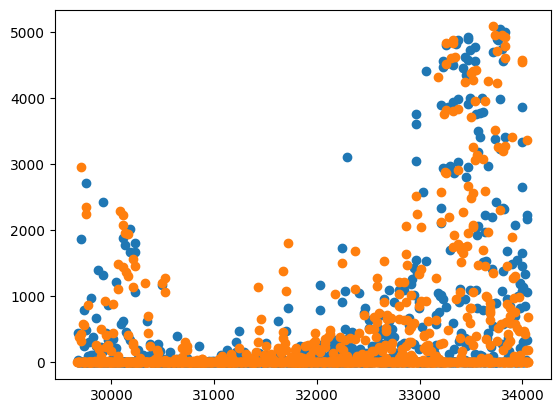

In [ ]:
import matplotlib.pyplot as plt

leaderboards = [None, None, None]
def leaderboard_for_location(i, loc):
    if use_test_data:
        lb = predictors[i].leaderboard(test_data[test_data["location"] == loc])
        lb["location"] = loc
        plt.scatter(test_data[test_data["location"] == loc]["y"].index, test_data[test_data["location"] == loc]["y"])
        if use_tune_data:
            plt.scatter(tuning_data[tuning_data["location"] == loc]["y"].index, tuning_data[tuning_data["location"] == loc]["y"])
        plt.show()

        return lb
    else:
        return pd.DataFrame()

leaderboards[0] = leaderboard_for_location(0, loc)

Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/submission_88_jorge_B/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   193.40 GB / 494.38 GB (39.1%)
Train Data Rows:    31020
Train Data Columns: 32
Tuning Data Rows:    898
Tuning Data Columns: 32
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1152.3, -0.0, 99.56591, 196.469)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ..

Training model for location B...


	Train Data (Processed) Memory Usage: 7.44 MB (0.2% of available memory)
Data preprocessing and feature engineering runtime = 0.11s ...
AutoGluon will gauge predictive performance using evaluation metric: 'mean_absolute_error'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	To change this, specify the eval_metric parameter of Predictor()
use_bag_holdout=True, will use tuning_data as holdout (will not be used for early stopping).
User-specified model hyperparameters to be fit:
{
	'NN_TORCH': {},
	'GBM': [{'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge'],
	'CAT': {},
	'XGB': {},
	'FASTAI': {},
	'RF': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'prob

[1000]	valid_set's l1: 38.2321


	Ran out of time, early stopping on iteration 1046. Best iteration is:
	[1046]	valid_set's l1: 38.1073
	Ran out of time, early stopping on iteration 873. Best iteration is:
	[873]	valid_set's l1: 36.4085
	Ran out of time, early stopping on iteration 996. Best iteration is:
	[996]	valid_set's l1: 35.534
	Ran out of time, early stopping on iteration 965. Best iteration is:
	[965]	valid_set's l1: 36.5645


[1000]	valid_set's l1: 36.9539


	Ran out of time, early stopping on iteration 1081. Best iteration is:
	[1081]	valid_set's l1: 36.756


[1000]	valid_set's l1: 36.6514


	Ran out of time, early stopping on iteration 1260. Best iteration is:
	[1260]	valid_set's l1: 35.9389


[1000]	valid_set's l1: 35.3685


	Ran out of time, early stopping on iteration 1214. Best iteration is:
	[1214]	valid_set's l1: 34.9732


[1000]	valid_set's l1: 35.7712


	Ran out of time, early stopping on iteration 1545. Best iteration is:
	[1544]	valid_set's l1: 34.8791
	-14.6596	 = Validation score   (-mean_absolute_error)
	52.54s	 = Training   runtime
	0.35s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 1.74s of the 1.74s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 7. Best iteration is:
	[7]	valid_set's l1: 102.15
	Ran out of time, early stopping on iteration 7. Best iteration is:
	[7]	valid_set's l1: 102.361
	Ran out of time, early stopping on iteration 7. Best iteration is:
	[7]	valid_set's l1: 99.9716
	Ran out of time, early stopping on iteration 9. Best iteration is:
	[9]	valid_set's l1: 96.894
	Ran out of time, early stopping on iteration 10. Best iteration is:
	[10]	valid_set's l1: 91.5466
	Ran out of time, early stopping on iteration 9. Best iteration is:
	[9]	valid_set's l1: 95.7494
	Ran out of tim

Evaluation on test data:
-18.13706437730951
                    model  score_test  score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L2  -18.137064 -14.267623        0.391011       1.041030  72.278823                 0.001461                0.000175           0.032812            2       True          4
1       LightGBMXT_BAG_L1  -18.178905 -14.659568        0.153278       0.353959  52.542051                 0.153278                0.353959          52.542051            1       True          1
2  RandomForestMSE_BAG_L1  -19.870953 -15.764196        0.236272       0.686896  19.703960                 0.236272                0.686896          19.703960            1       True          3
3         LightGBM_BAG_L1  -80.891529 -73.799636        0.011217       0.016561   1.667307                 0.011217                0.016561           1.667307            1       Tr

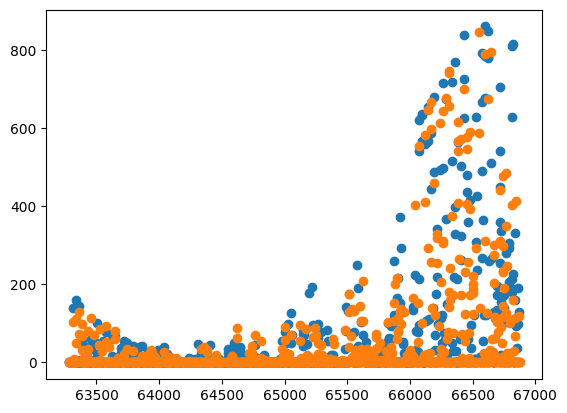

In [ ]:
loc = "B"
predictors[1] = fit_predictor_for_location(loc)
leaderboards[1] = leaderboard_for_location(1, loc)

Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/submission_88_jorge_C/"
AutoGluon Version:  0.8.1
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   193.35 GB / 494.38 GB (39.1%)
Train Data Rows:    24594
Train Data Columns: 32
Tuning Data Rows:    737
Tuning Data Columns: 32
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (999.6, -0.0, 79.8926, 168.407)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data

Training model for location C...


Data preprocessing and feature engineering runtime = 0.12s ...
AutoGluon will gauge predictive performance using evaluation metric: 'mean_absolute_error'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	To change this, specify the eval_metric parameter of Predictor()
use_bag_holdout=True, will use tuning_data as holdout (will not be used for early stopping).
User-specified model hyperparameters to be fit:
{
	'NN_TORCH': {},
	'GBM': [{'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge'],
	'CAT': {},
	'XGB': {},
	'FASTAI': {},
	'RF': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
	'XT': [{'criterion': 'gini', 

Evaluation on test data:
-23.919330697836322
                   model  score_test  score_val  pred_time_test  pred_time_val  fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  KNeighborsDist_BAG_L1  -23.919331 -23.699494        4.526010     118.633113  0.018868                 4.526010              118.633113           0.018868            1       True          1
1    WeightedEnsemble_L2  -23.919331 -23.699494        4.526935     118.633293  0.021883                 0.000925                0.000180           0.003015            2       True          2


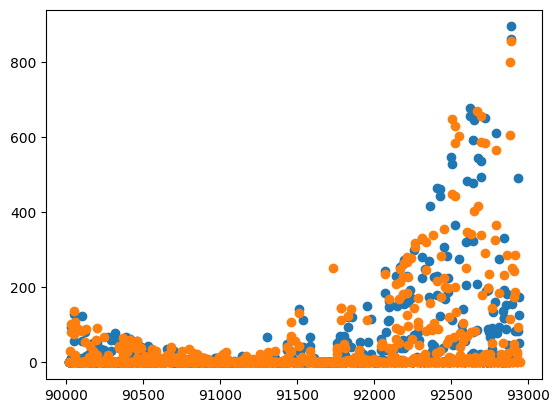

In [ ]:
loc = "C"
predictors[2] = fit_predictor_for_location(loc)
leaderboards[2] = leaderboard_for_location(2, loc)

In [ ]:
# save leaderboards to csv
pd.concat(leaderboards).to_csv(f"leaderboards/{new_filename}.csv")

# Submit

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

future_test_data = TabularDataset('X_test_raw.csv')
future_test_data["ds"] = pd.to_datetime(future_test_data["ds"])
#test_data

Loaded data from: X_test_raw.csv | Columns = 34 / 34 | Rows = 4608 -> 4608


In [ ]:
test_ids = TabularDataset('test.csv')
test_ids["time"] = pd.to_datetime(test_ids["time"])
# merge test_data with test_ids
future_test_data_merged = pd.merge(future_test_data, test_ids, how="inner", right_on=["time", "location"], left_on=["ds", "location"])

#test_data_merged

Loaded data from: test.csv | Columns = 4 / 4 | Rows = 2160 -> 2160


In [ ]:
# predict, grouped by location
predictions = []
location_map = {
    "A": 0,
    "B": 1,
    "C": 2
}
for loc, group in future_test_data.groupby('location'):
    i = location_map[loc]
    subset = future_test_data_merged[future_test_data_merged["location"] == loc].reset_index(drop=True)
    #print(subset)
    pred = predictors[i].predict(subset)
    subset["prediction"] = pred
    predictions.append(subset)

    # get past predictions
    train_data.loc[train_data["location"] == loc, "prediction"] =  predictors[i].predict(train_data[train_data["location"] == loc])
    if use_tune_data:
        tuning_data.loc[tuning_data["location"] == loc, "prediction"] =  predictors[i].predict(tuning_data[tuning_data["location"] == loc])
    if use_test_data:
        test_data.loc[test_data["location"] == loc, "prediction"] =  predictors[i].predict(test_data[test_data["location"] == loc])  

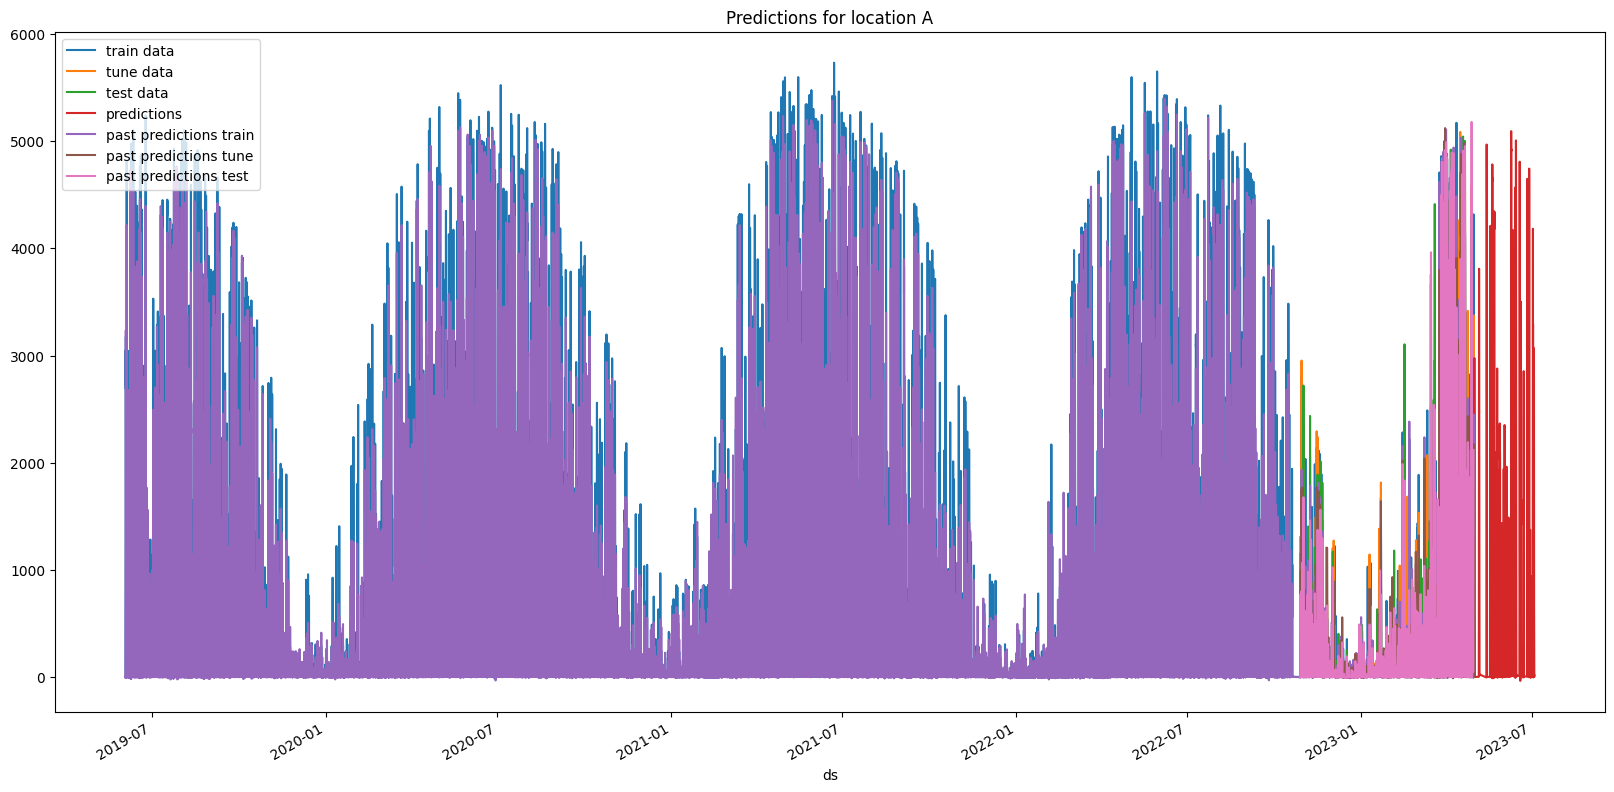

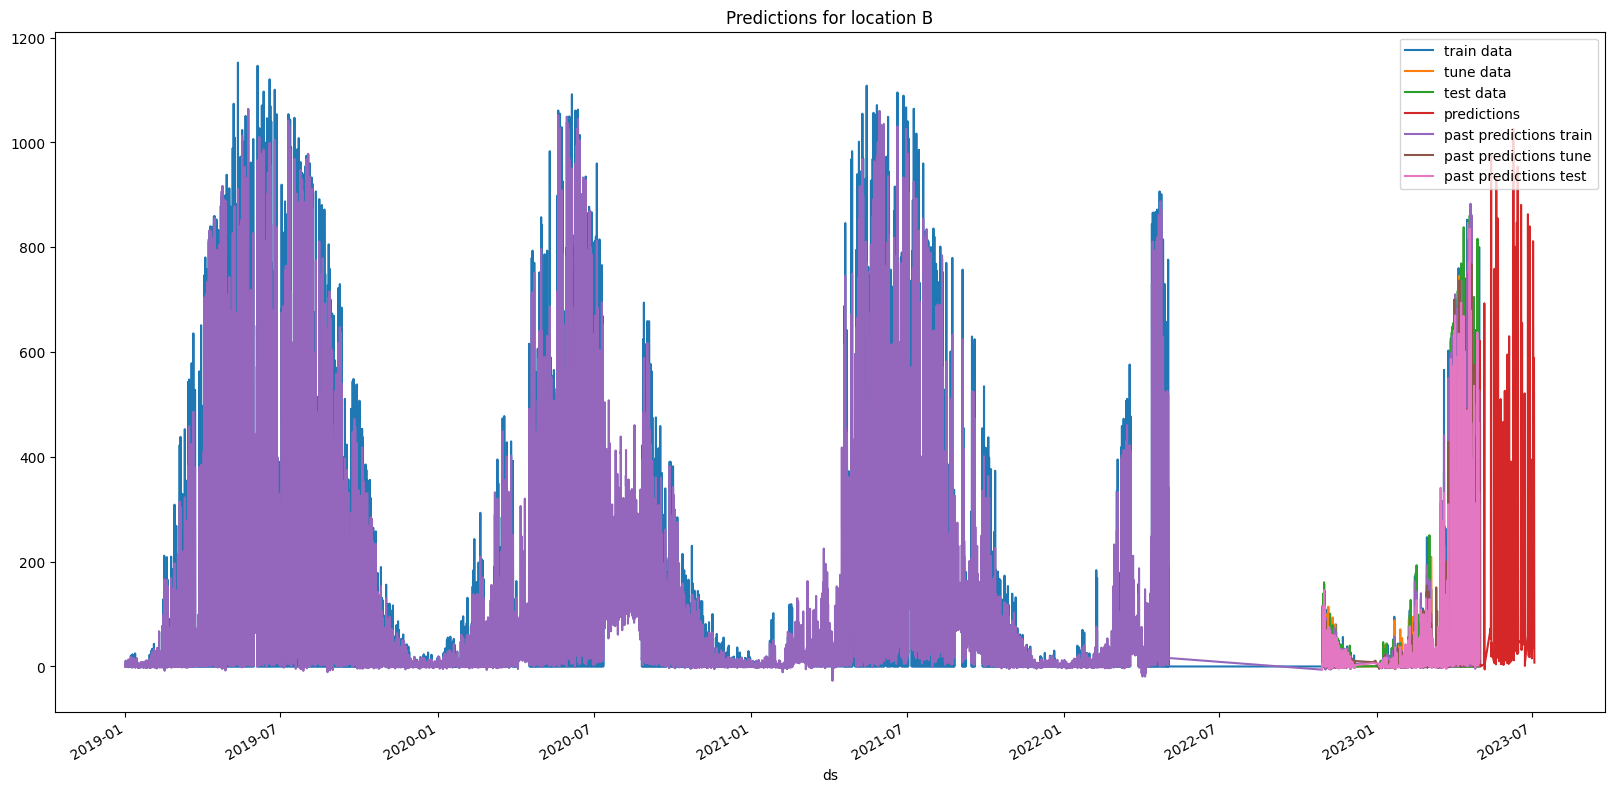

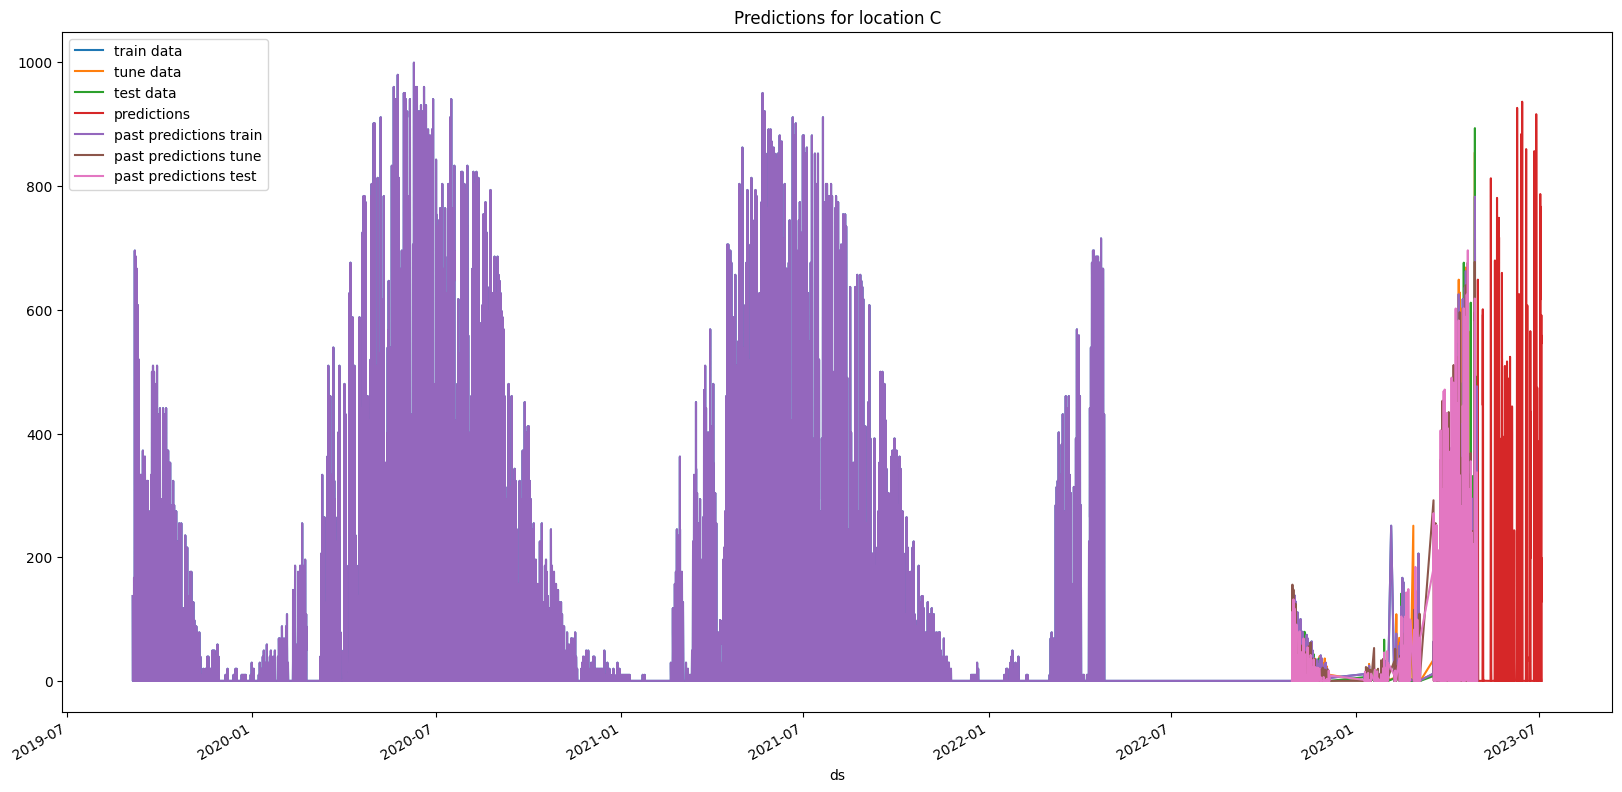

In [ ]:
# plot predictions for location A, in addition to train data for A
for loc, idx in location_map.items():
    fig, ax = plt.subplots(figsize=(20, 10))
    # plot train data
    train_data[train_data["location"]==loc].plot(x='ds', y='y', ax=ax, label="train data")
    if use_tune_data:
        tuning_data[tuning_data["location"]==loc].plot(x='ds', y='y', ax=ax, label="tune data")
    if use_test_data:
        test_data[test_data["location"]==loc].plot(x='ds', y='y', ax=ax, label="test data")

    # plot predictions
    predictions[idx].plot(x='ds', y='prediction', ax=ax, label="predictions")

    # plot past predictions
    #train_data_with_dates[train_data_with_dates["location"]==loc].plot(x='ds', y='prediction', ax=ax, label="past predictions")
    train_data[train_data["location"]==loc].plot(x='ds', y='prediction', ax=ax, label="past predictions train")
    if use_tune_data:
        tuning_data[tuning_data["location"]==loc].plot(x='ds', y='prediction', ax=ax, label="past predictions tune")
    if use_test_data:
        test_data[test_data["location"]==loc].plot(x='ds', y='prediction', ax=ax, label="past predictions test")


    # title
    ax.set_title(f"Predictions for location {loc}")

In [ ]:
temp_predictions = [prediction.copy() for prediction in predictions]
if clip_predictions:
    # clip predictions smaller than 0 to 0
    for pred in temp_predictions:
        # print smallest prediction
        print("Smallest prediction:", pred["prediction"].min())
        pred.loc[pred["prediction"] < 0, "prediction"] = 0
        print("Smallest prediction after clipping:", pred["prediction"].min())

# Instead of clipping, shift all prediction values up by the largest negative number.
# This way, the smallest prediction will be 0.
elif shift_predictions:
    for pred in temp_predictions:
        # print smallest prediction
        print("Smallest prediction:", pred["prediction"].min())
        pred["prediction"] = pred["prediction"] - pred["prediction"].min()
        print("Smallest prediction after clipping:", pred["prediction"].min())

elif shift_predictions_by_average_of_negatives_then_clip:
    for pred in temp_predictions:
        # print smallest prediction
        print("Smallest prediction:", pred["prediction"].min())
        mean_negative = pred[pred["prediction"] < 0]["prediction"].mean()
        # if not nan
        if mean_negative == mean_negative:
            pred["prediction"] = pred["prediction"] - mean_negative

        pred.loc[pred["prediction"] < 0, "prediction"] = 0
        print("Smallest prediction after clipping:", pred["prediction"].min())



# concatenate predictions
submissions_df = pd.concat(temp_predictions)
submissions_df = submissions_df[["id", "prediction"]]
submissions_df

Smallest prediction: -37.320892
Smallest prediction after clipping: 0.0
Smallest prediction: -5.533494
Smallest prediction after clipping: 0.0
Smallest prediction: 0.0
Smallest prediction after clipping: 0.0


,id,prediction
0,0,3.067109
1,1,3.120187
2,2,4.676383
3,3,62.207722
4,4,332.853882
...,...,...
715,2155,62.320900
716,2156,4.477107
717,2157,0.000000
718,2158,0.000000


In [ ]:



# Save the submission DataFrame to submissions folder, create new name based on last submission, format is submission_<last_submission_number + 1>.csv

# Save the submission
print(f"Saving submission to submissions/{new_filename}.csv")
submissions_df.to_csv(os.path.join('submissions', f"{new_filename}.csv"), index=False)
print("jall1a")

Saving submission to submissions/submission_88_jorge.csv
jall1a


In [ ]:
# feature importance
# print starting calculating feature importance for location A with big text font
print("\033[1m" + "Calculating feature importance for location A..." + "\033[0m")
predictors[0].feature_importance(feature_stage="original", data=test_data[test_data["location"] == "A"], time_limit=60*10)
print("\033[1m" + "Calculating feature importance for location B..." + "\033[0m")
predictors[1].feature_importance(feature_stage="original", data=test_data[test_data["location"] == "B"], time_limit=60*10)
print("\033[1m" + "Calculating feature importance for location C..." + "\033[0m")
predictors[2].feature_importance(feature_stage="original", data=test_data[test_data["location"] == "C"], time_limit=60*10)

These features in provided data are not utilized by the predictor and will be ignored: ['ds', 'elevation:m', 'location', 'prediction']


Computing feature importance via permutation shuffling for 30 features using 1094 rows with 10 shuffle sets... Time limit: 600s...


Calculating feature importance for location A...


	156.5s	= Expected runtime (15.65s per shuffle set)
	25.71s	= Actual runtime (Completed 10 of 10 shuffle sets)
These features in provided data are not utilized by the predictor and will be ignored: ['ds', 'elevation:m', 'location', 'prediction']
Computing feature importance via permutation shuffling for 30 features using 899 rows with 10 shuffle sets... Time limit: 600s...


Calculating feature importance for location B...


	102.93s	= Expected runtime (10.29s per shuffle set)
	23.8s	= Actual runtime (Completed 10 of 10 shuffle sets)
These features in provided data are not utilized by the predictor and will be ignored: ['ds', 'elevation:m', 'location', 'prediction']
Computing feature importance via permutation shuffling for 30 features using 738 rows with 10 shuffle sets... Time limit: 600s...


Calculating feature importance for location C...


	923.98s	= Expected runtime (92.4s per shuffle set)
	1199.09s	= Actual runtime (Completed 1 of 10 shuffle sets) (Early stopping due to lack of time...)


,importance,stddev,p_value,n,p99_high,p99_low
clear_sky_energy_1h:J,2.616581e+01,NaN,NaN,1,NaN,NaN
direct_rad_1h:J,5.419074e+00,NaN,NaN,1,NaN,NaN
diffuse_rad_1h:J,2.570512e+00,NaN,NaN,1,NaN,NaN
visibility:m,1.670340e-01,NaN,NaN,1,NaN,NaN
sun_azimuth:d,8.146472e-03,NaN,NaN,1,NaN,NaN
total_cloud_cover:p,3.136587e-03,NaN,NaN,1,NaN,NaN
effective_cloud_cover:p,3.112687e-03,NaN,NaN,1,NaN,NaN
sun_elevation:d,6.540081e-04,NaN,NaN,1,NaN,NaN
msl_pressure:hPa,6.339658e-04,NaN,NaN,1,NaN,NaN
sfc_pressure:hPa,6.338293e-04,NaN,NaN,1,NaN,NaN


In [ ]:
# save this notebook to submissions folder
import subprocess
import os
subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}_automatic_save.pdf"), "autogluon_each_location.ipynb"])
#subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}.pdf"), "autogluon_each_location.ipynb"])

[NbConvertApp] Converting notebook autogluon_each_location.ipynb to pdf
[NbConvertApp] Support files will be in notebook_pdfs/submission_88_jorge_files/
[NbConvertApp] Making directory ./notebook_pdfs/submission_88_jorge_files/notebook_pdfs
[NbConvertApp] Writing 164979 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 225414 bytes to notebook_pdfs/submission_88_jorge.pdf


CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'notebook_pdfs/submission_88_jorge.pdf', 'autogluon_each_location.ipynb'], returncode=0)

In [ ]:
# import subprocess

# def execute_git_command(directory, command):
#     """Execute a Git command in the specified directory."""
#     try:
#         result = subprocess.check_output(['git', '-C', directory] + command, stderr=subprocess.STDOUT)
#         return result.decode('utf-8').strip(), True
#     except subprocess.CalledProcessError as e:
#         print(f"Git command failed with message: {e.output.decode('utf-8').strip()}")
#         return e.output.decode('utf-8').strip(), False

# git_repo_path = "."

# execute_git_command(git_repo_path, ['config', 'user.email', 'henrikskog01@gmail.com'])
# execute_git_command(git_repo_path, ['config', 'user.name', hello if hello is not None else 'Henrik eller Jørgen'])

# branch_name = new_filename

# # add datetime to branch name
# branch_name += f"_{pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')}"

# commit_msg = "run result"

# execute_git_command(git_repo_path, ['checkout', '-b',branch_name])

# # Navigate to your repo and commit changes
# execute_git_command(git_repo_path, ['add', '.'])
# execute_git_command(git_repo_path, ['commit', '-m',commit_msg])

# # Push to remote
# output, success = execute_git_command(git_repo_path, ['push', 'origin',branch_name])

# # If the push fails, try setting an upstream branch and push again
# if not success and 'upstream' in output:
#     print("Attempting to set upstream and push again...")
#     execute_git_command(git_repo_path, ['push', '--set-upstream', 'origin',branch_name])
#     execute_git_command(git_repo_path, ['push', 'origin', 'henrik_branch'])

# execute_git_command(git_repo_path, ['checkout', 'main'])